In [1]:

from monai.transforms import (Compose)
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
import numpy as np
from monai.transforms import Compose, Invertd, SaveImaged
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
import torch
import json


In [2]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
ga_output_dir = config["ga_output_dir"]
artifact_dir = config["artifacts"]
artifact_output = config ["artifact_output"]
fdg_output_dir = config['fdg_output_dir']


In [3]:
# from data_preparation import ExtrenalRadioSetSetHandling

# data_handler = ExtrenalRadioSetSetHandling(fdg_data_dir, train_mode="NAC", target_mode="MAC")

# test_files = data_handler.get_data()
# print(len(test_files))


In [3]:
from data_preparation import ExternalRadioSetHandling

data_handler = ExternalRadioSetHandling(data_dir=fdg_data_dir, test_ratio=0.2)
train_files, val_files, test_files = data_handler.get_split_data()

print(f"Test data length: {len(test_files)}")
print(f"Validation data length: {len(val_files)}")
print(f"Train data length: {len(train_files)}")

Test data length: 21
Validation data length: 15
Train data length: 62


In [12]:

from data_preparation import LoaderFactory
loader_factory = LoaderFactory(
    train_files=None,
    val_files=None,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    # spacing = [1.92, 1.92, 3.27], # For fdg data
    # spatial_size = (168, 168, 400)
    # spatial_size = (336, 336, 640) # for Fdg data
    spatial_size = (168, 168, 600)
    )

test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)



In [6]:
from utils import find_last_saved_model, parse_loss_values

# log_filename = 'log_2_26_8_17.txt' # saved on hard
# log_filename = 'log_3_4_12_4.txt' # saved on hard
# log_filename = 'log_3_4_12_41.txt' # saved on hard
# log_filename = 'log_3_18.txt'
# log_filename = 'log_3_27_8_47.txt'
# log_filename = 'log_3_28_6_8.txt'
# log_filename = 'log_3_28_10_41.txt'
# log_filename = 'log_3_28_20_48.txt'
log_filename = 'log_3_29_6_54.txt' # adcm final model for 11 april is here
# log_filename = 'log_4_6_8_55.txt'


log_filepath = log_dir + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_4_1_1_45.pth, Best Metric: 0.3435, Epoch: 180


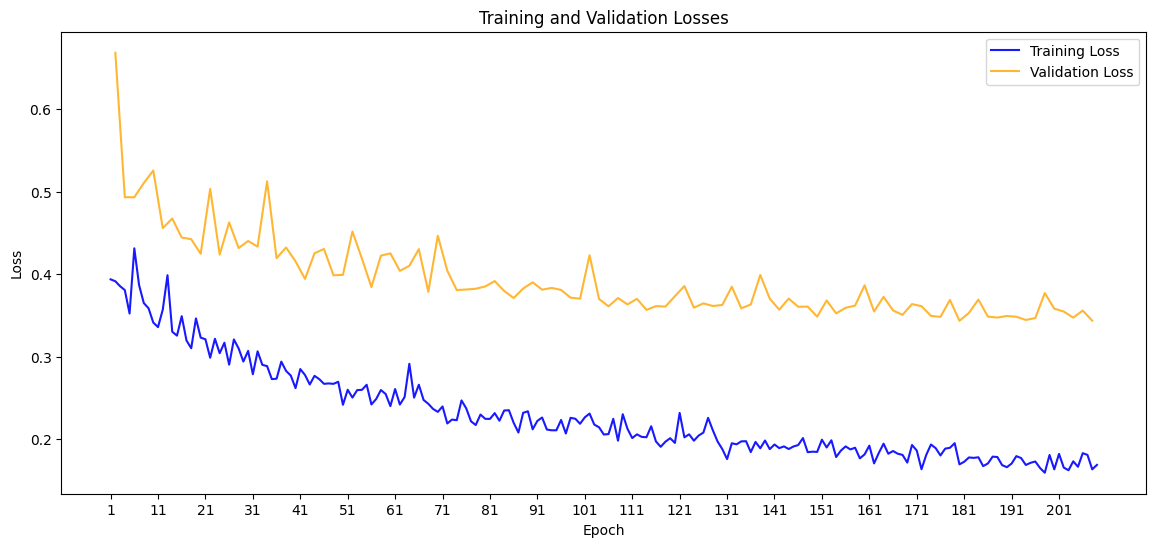

In [13]:
train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 10))  # Adjust the x-axis ticks if needed
plt.show()


In [7]:
import os
import torch
from model_maker import get_network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_network(patch_size = [168, 168, 16], spacing = [4.07, 4.07, 3.00])

model = model.to(device)


DyUnet is set:
Kernel size:  [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides:  [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 1]]


In [8]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(log_dir, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

Model file model_4_1_1_45.pth is loading.


In [9]:
# Extract file names
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]
test_name


[('006006_dataset_07_A.nii', '006006_dataset_07_A.nii'),
 ('006010_dataset_07_A.nii', '006010_dataset_07_A.nii'),
 ('006051_dataset_07_A.nii', '006051_dataset_07_A.nii'),
 ('005073_dataset_06_A.nii', '005073_dataset_06_A.nii'),
 ('005060_dataset_06_A_nac_6.nii', '005060_dataset_06_A_nac_6.nii'),
 ('005002_dataset_06_A_nac_6.nii', '005002_dataset_06_A_nac_6.nii'),
 ('005106_dataset_06_A.nii', '005106_dataset_06_A.nii'),
 ('005039_dataset_06_A.nii', '005039_dataset_06_A.nii'),
 ('005005_dataset_06_A.nii', '005005_dataset_06_A.nii'),
 ('005043_dataset_06_A_nac_3.nii', '005043_dataset_06_A_nac_3.nii'),
 ('006044_dataset_07_A.nii', '006044_dataset_07_A.nii'),
 ('006046_dataset_07_A.nii', '006046_dataset_07_A.nii'),
 ('006024_dataset_07_A.nii', '006024_dataset_07_A.nii'),
 ('006041_dataset_07_A.nii', '006041_dataset_07_A.nii'),
 ('006037_dataset_07_A.nii', '006037_dataset_07_A.nii'),
 ('005037_dataset_06_A.nii', '005037_dataset_06_A.nii'),
 ('006007_dataset_07_A.nii', '006007_dataset_07_A.ni

100%|██████████| 2/2 [01:02<00:00, 31.25s/it]


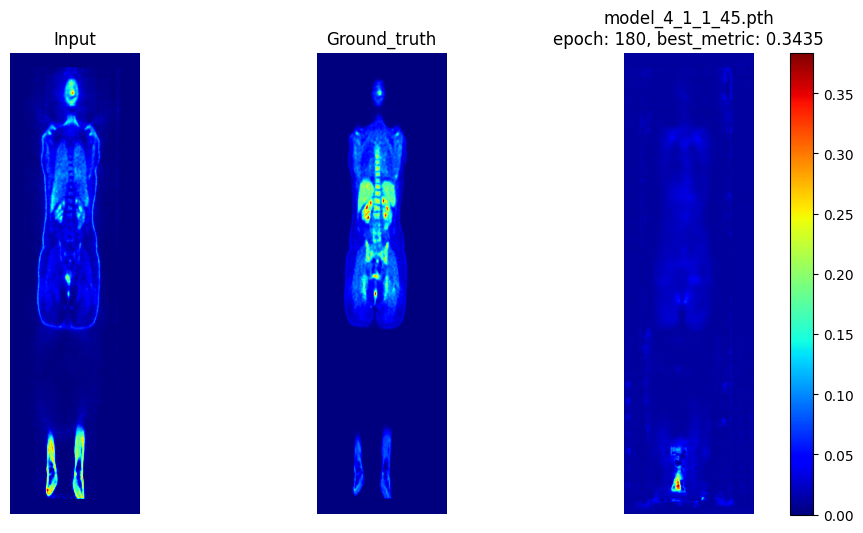

In [14]:
import torch
from data_preparation import visualize_coronal_slice

roi_size = (160, 160, 32)
sw_batch_size = 64
slice_number = 100

with torch.no_grad():
    for i, data in enumerate(test_loader):

        predict = sliding_window_inference(data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.30)
        
        visualize_coronal_slice(data, predict, slice_number, 
                                f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}", 
                                "jet", Norm=False)
        if i == 0:
            break


In [15]:

from monai.transforms import Compose
from data_preparation import ClampNegative


roi_size = (160, 160, 32)
sw_batch_size = 64


post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=loader_factory.get_test_transforms(),
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        ClampNegative(keys=["pred"]),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=fdg_output_dir, output_postfix="dl_adcm_3_29_v2", resample=False), 
    ]
)

with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.70)
        post_processed = [post_transforms(i) for i in decollate_batch(test_data)]



Minimum negative value in pred: -5.082561016082764
2024-04-12 06:39:40,964 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/FDG_OUTPUT/006006_dataset_07_A/006006_dataset_07_A_dl_adcm_3_29_v2.nii.gz
Minimum negative value in pred: -2.905097723007202
2024-04-12 06:42:49,892 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/FDG_OUTPUT/006010_dataset_07_A/006010_dataset_07_A_dl_adcm_3_29_v2.nii.gz
Minimum negative value in pred: -10.588973999023438
2024-04-12 06:45:13,050 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/FDG_OUTPUT/006051_dataset_07_A/006051_dataset_07_A_dl_adcm_3_29_v2.nii.gz
Minimum negative value in pred: -1.2056467533111572
2024-04-12 06:47:51,870 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/FDG_OUTPUT/005073_dataset_06_A/005073_dataset_06_A_dl_adcm_3_29_v2.nii.gz
Minimum negative value in pred: -3.072326421737671
2024-04-12 06:50:08,043 INFO image_writer.py:197 - writing:

In [ ]:


# # Define a function for visualization
# def visualize_results(val_data, model, n, title):

#     val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
#                           sw_batch_size, model, progress=True, overlap=0.90) # using ov= 0.9 best image ever I have.


#     plt.figure("check", (12, 6))

#     plt.subplot(1, 3, 1)
#     plt.title(f"Input")
#     input_slice = np.rot90(val_data["image"][0, 0, :, n, :])
#     plt.imshow(input_slice, cmap="jet")

#     plt.subplot(1, 3, 2)
#     plt.title(f"Ground_truth")
#     target_slice = np.rot90(val_data["target"][0, 0, :, n, :])
#     plt.imshow(target_slice, cmap="jet")

#     plt.subplot(1, 3, 3)
#     plt.title(title)
#     output_slice = np.rot90(val_outputs.detach().cpu()[0, 0, :, n, :])
#     plt.imshow(output_slice, cmap="jet")
    
#     plt.show()


# roi_size = (168, 168, 32)
# sw_batch_size = 16
# with torch.no_grad():
#     for i, val_data in enumerate(test_org_loader):

#         n = 80
#         visualize_results(val_data, model, n, f"{bestmodel_filename}\nepoch: { best_epoch}, best_metric: {best_metric}")
#         if i == 1:
#             break




----
# Export dl_adcm images

In [ ]:
# # Extract file names
# roi_size = (168, 168, 32)
# sw_batch_size = 16
# post_transforms = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=test_transforms,
#             orig_keys="target",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="target_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#         ),
#         SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=output_dir, output_postfix="test", resample=False),
#     ]
# )
# model.eval()

# with torch.no_grad():
#     for test_data in test_org_loader:
#         test_inputs = test_data["image"].to(device)
#         test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.90)
#         print("Metadata before inversion:", test_data["pred"].meta)

#         inverted_data = [post_transforms(i) for i in decollate_batch(test_data)]
#         print("Metadata after inversion:", inverted_data[0]["pred"].meta)

In [ ]:
# import nibabel as nib

# # Load the saved image
# dl_image_path = '/students/2023-2024/master/Shahpouri/OUTPUT/005002_dataset_06_A_nac_6/005002_dataset_06_A_nac_6_test.nii.gz' 
# original_image_path = '/students/2023-2024/master/Shahpouri/DATA/FDG-PET/MAC/005002_dataset_06_A_nac_6.nii.gz'
# orig = nib.load(original_image_path)
# dl = nib.load(dl_image_path)


# # Check qform and sform of the original image
# print("Original image qform code:", orig.header['qform_code'])
# print("Original image qform matrix:\n", orig.get_qform())
# print("Original image sform code:", orig.header['sform_code'])
# print("Original image sform matrix:\n", orig.get_sform())

# print("-----------------------")
# print("dl image qform code:", dl.header['qform_code'])
# print("dl image qform matrix:\n", dl.get_qform())
# print("dl image sform code:", dl.header['sform_code'])
# print("dl image sform matrix:\n", dl.get_sform())


In [ ]:
# import nibabel as nib
# import numpy as np

# original_image_path = '/students/2023-2024/master/Shahpouri/DATA/FDG-PET/MAC/005002_dataset_06_A_nac_6.nii.gz'
# dl_image_path = '/students/2023-2024/master/Shahpouri/OUTPUT/005002_dataset_06_A_nac_6/005002_dataset_06_A_nac_6_test.nii.gz'
# corrected_dl_image_path = '/students/2023-2024/master/Shahpouri/OUTPUT/005002_dataset_06_A_nac_6/005002_dataset_06_A_nac_6_corrected.nii.gz'

# orig = nib.load(original_image_path)
# dl = nib.load(dl_image_path)
# dl_data = dl.get_fdata()
# print(dl_data)
# corrected_dl_img = nib.Nifti1Image(dl_data, orig.affine, header=orig.header.copy())

# # Save the DL image with the updated header
# nib.save(corrected_dl_img, corrected_dl_image_path)

# # Load the newly saved image to check the affine matrix
# dl_new = nib.load(corrected_dl_image_path)

# print("Affine matrix for dl_corrected image:", orig.affine)
# print("Affine matrix for dl_corrected image:", dl.affine)
# print("Affine matrix for dl_correcdted image:", dl_new.affine)
